Module for calculating lattice filter parameters for PIC implementation

## Imports

In [11]:
!{sys.executable} -m pip install -r dependencies/requirements.txt

ERROR: Invalid requirement: 'numpy#==2.3.3': Expected end or semicolon (after name and no valid version specifier)
    numpy#==2.3.3
         ^ (from line 3 of dependencies/requirements.txt)


In [12]:
#!pip list

In [13]:
%run Functions.py # run the functions file with the imported libraries and functions

warnings.filterwarnings("ignore", message="findfont:")  # Ignore 'findfont' warnings

from sympy import symbols
z = symbols('z', complex = True); ω = symbols('ω', real = True); π = np.pi

simulationband = [1450e-9, 1650e-9]
cband = [1525e-9, 1570e-9]
points =10001
plt.style.use(['ieee', 'grid'])

## Second Order Test

In [14]:
# Initial definitions 
l = 50e-6
simulationband = [1450e-9, 1650e-9]
lambda_0=1550e-9
cband = [1525e-9, 1570e-9]
ng = 4.2 # Silicon waveguide group index
neff = 2.44
dx = 125

N = 2
points =10001

In [15]:
theta, phi, a, b, deltaL = filter_with_indexes(N=N, idx=[3, 4, 5], 
                                               type='maximally_flat', fsr=25e-9, ng=ng, lambda_0=lambda_0)
df_thetas = thetas_phis_df(theta, phi, verbose=True)
display(Latex(f"The $\\Delta L$ for the desired FSR is: {deltaL*1e6:.4f} $\\mu m$"))
theta

Order,Theta (π),k,Phi
Theta2,-0.2500π,0.50000,-3.1416
Theta1,-0.3333π,0.74995,-0.0000
Theta0,-0.4167π,0.93304,--------


<IPython.core.display.Latex object>

array([-0.78539816, -1.04713899, -1.30905548])

In [16]:
if 'inter' not in locals():
    lumapi = lumapi()
    inter = lumapi.INTERCONNECT()

C:\Program Files\Lumerical\v242\api\python\lumapi.py:895: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


found!
version v202 not found...
version v221 not found...
version v231 not found...
version v241 not found...
version v242 found!
import not found


In [17]:
try:
    inter.switchtolayout()
except:
    pass

inter.selectall()
inter.delete()


theta_values_order3 = [theta[2], theta[1], theta[0]]
phi_values_order3 = [phi[2], phi[1]]

create_mzi_of_order(
    inter=inter, 
    order=N,
    thetas=theta_values_order3,
    phis=phi_values_order3,
    points=points,
)
inter.switchtolayout()
print("Running simulation...")
inter.run()

upper_transmission2 = abs(inter.getresult('ONA_1', 'input 1/mode 1/transmission')['TE transmission'])**2
lower_transmission2 = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2

Starting the creation of a 2-order MZI...
Connecting elements...
Running simulation...


In [18]:
# Plotting the results
λ = np.linspace(simulationband[0]*1e9, simulationband[-1]*1e9, points)

A2 = sum(coeff * z**(-i) for i, coeff in enumerate(a))
B2 = sum(coeff * z**(-i) for i, coeff in enumerate(b))

# Transforming Z domain to frequency
A2_freq = A2.subs(z, exp(I * ω))
B2_freq = B2.subs(z, exp(I * ω))

# Generating numerical function
A2_freq_func = sp.lambdify(ω, A2_freq, 'numpy')
B2_freq_func = sp.lambdify(ω, B2_freq, 'numpy')

# Obtaining the values for omega_vals
desired_fsr = 25e-9
pi_limits = (simulationband[0]-simulationband[-1])/desired_fsr*π # Calculate the omega span
phase = 0 # allign the value with the desired phase
omega_vals = np.linspace(-pi_limits+phase, pi_limits+phase, points) # Setting the omega values for the FSR calculation and optimization
#print(-pi_limits)
A2_vals = np.abs(A2_freq_func(omega_vals))
B2_vals = np.abs(B2_freq_func(omega_vals))


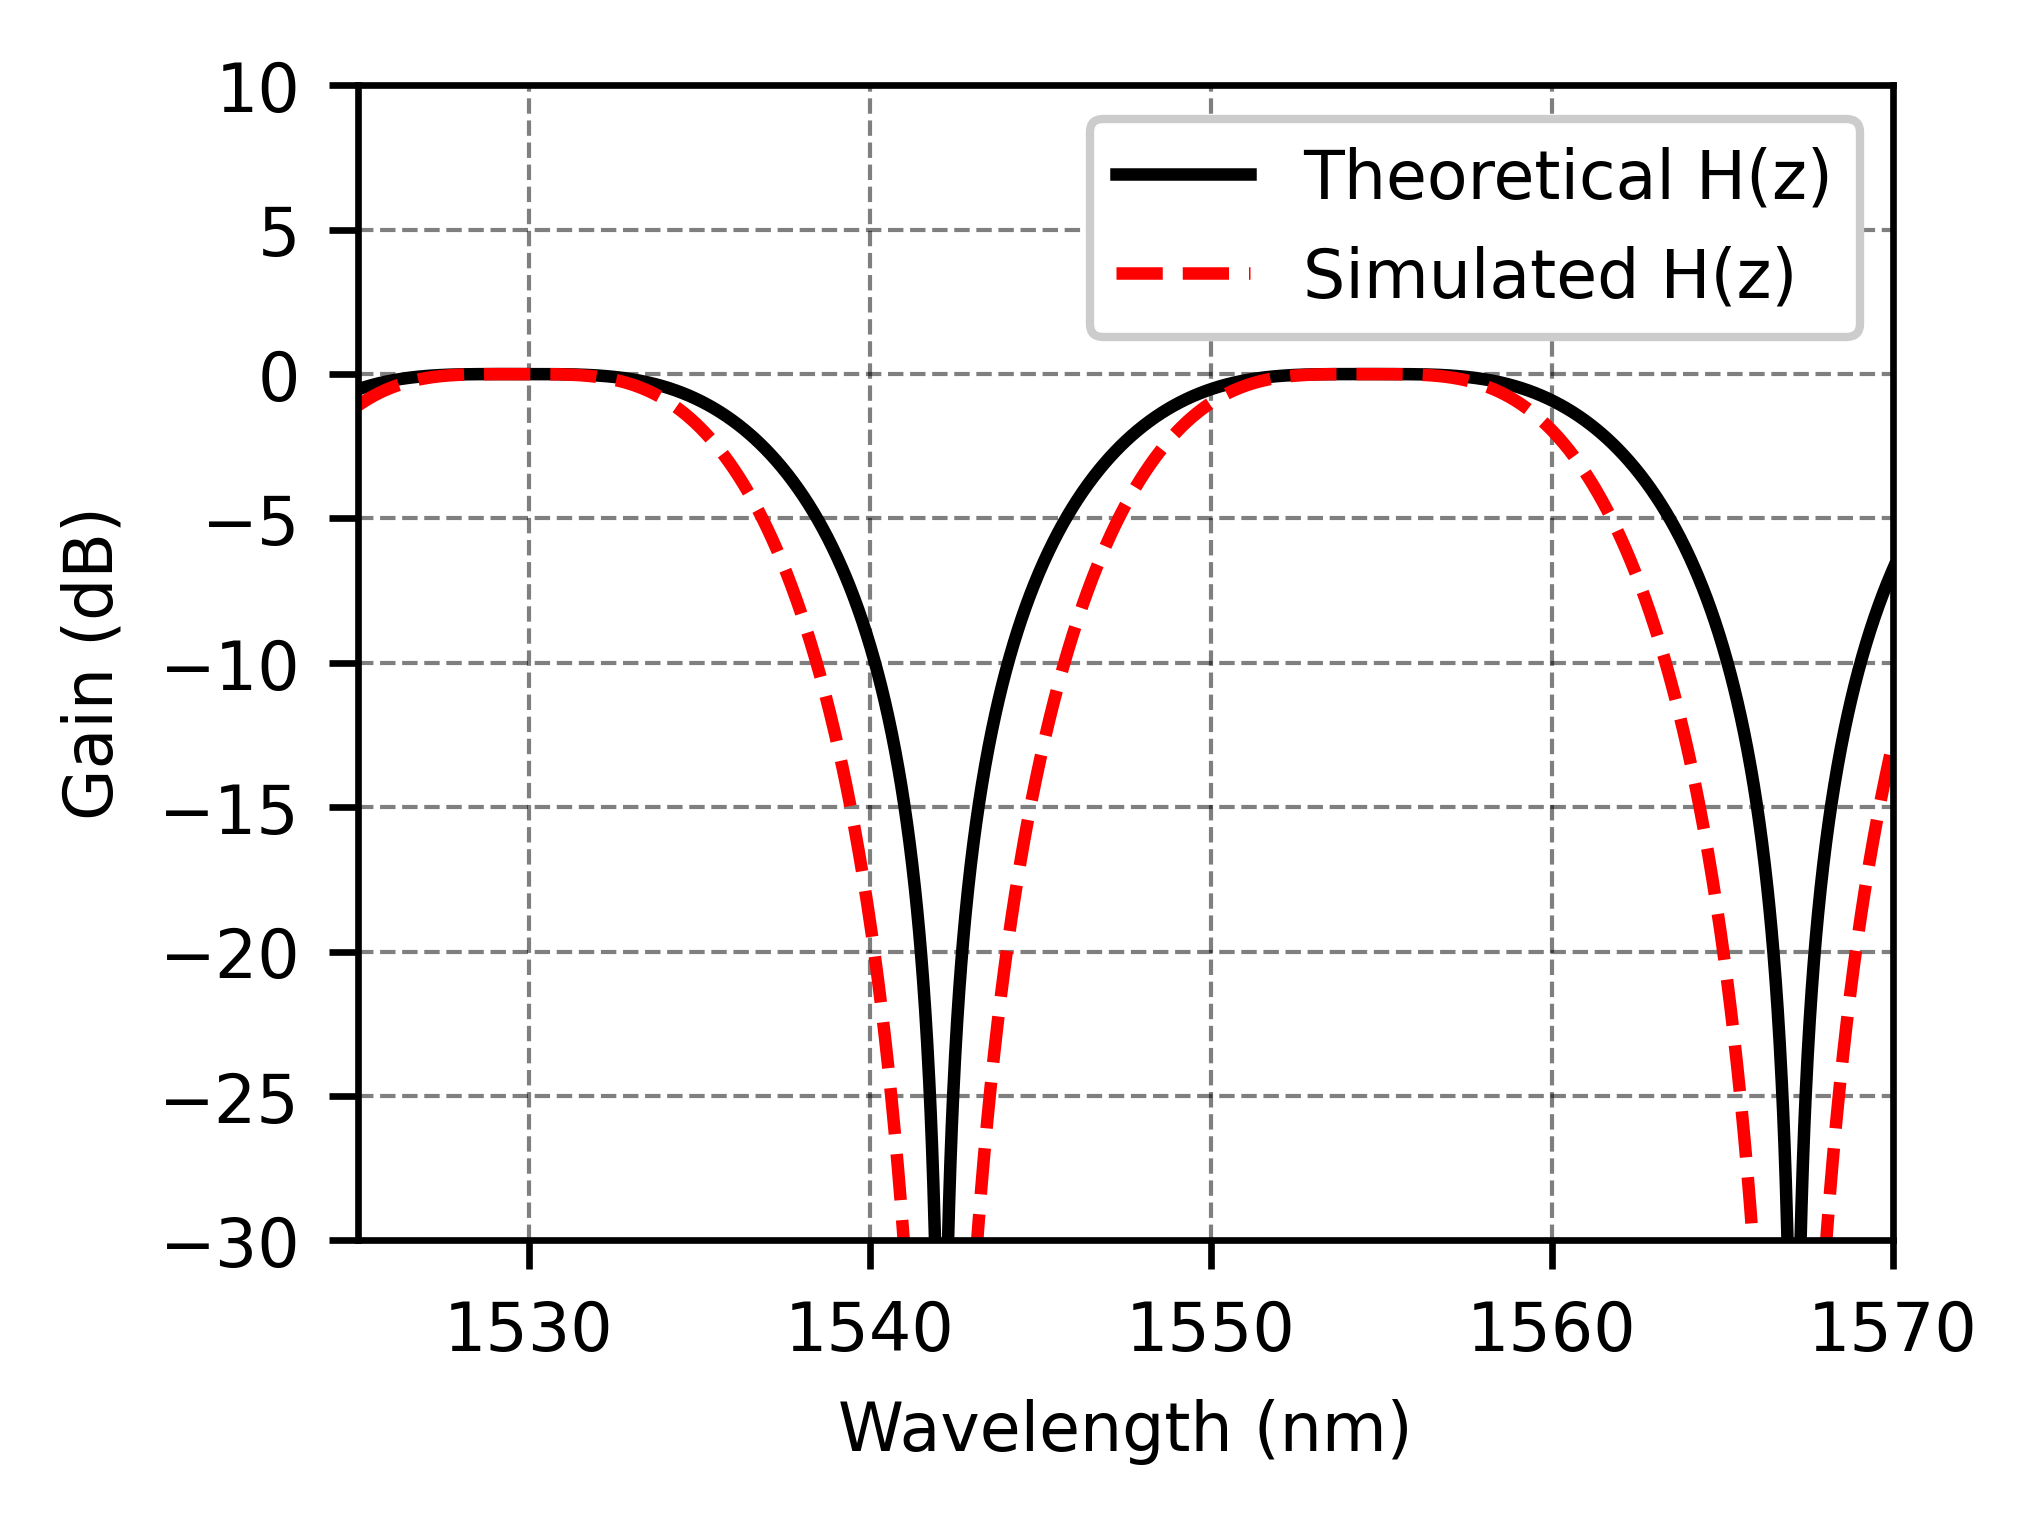

In [19]:
plt.figure();

delay, a1, a2_shifted = find_delay(lower_transmission2, B2_vals)

plt.grid(True)
plt.plot(λ, 10*np.log10(np.roll(B2_vals,delay)), label='Theoretical H(z)');#, marker='^', markevery=3000, ms=4)
plt.plot(λ, 10*np.log10(lower_transmission2), label='Simulated H(z)');#, marker='o', markevery=3000, ms=3)
plt.ylabel('Gain (dB)');
plt.legend(loc='upper right');
plt.xlabel('Wavelength (nm)');
plt.xlim(cband[0]*1e9,cband[-1]*1e9)
plt.ylim(-30, 10);
plt.xticks();
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


# Third Order Test


In [20]:
# Initial definitions 
l = 50e-6
simulationband = [1450e-9, 1650e-9]
lambda_0=1550e-9
cband = [1525e-9, 1570e-9]
ng = 4.2 # Silicon waveguide group index
neff = 2.44
dx = 125

In [21]:
if 'inter' not in locals():
    lumapi = lumapi()
    inter = lumapi.INTERCONNECT()

In [22]:
N = 3

# Call the main function to get the paired coefficients
# Note: find_filter_pairs returns a single list of matched pairs.
paired_filters = find_filter_pairs(N=N, verbose=True, imag_threshold=1e-3, a0_precision=5)

print("\n--- Output Vector of Matched Coefficient Pairs ---")
if not paired_filters:
    print("No matched pairs were found.")
else:
    for i, pair in enumerate(paired_filters):
        print(f"\nPair #{i+1}")
        print(f"G(z) Coeffs (ak): {np.round(pair[0], 5)}")
        print(f"H(z) Coeffs (bk): {np.round(pair[1], 5)}")

--- Generating filters for N=3 and type='maximally_flat' ---

--- Processing A_k to find unique G(z) filters ---
Testing 252 root combinations for A_k...
Found 32 unique G(z) candidates.

--- Processing B_k to find unique H(z) filters ---
Testing 252 root combinations for B_k...
Found 32 unique H(z) candidates.

--- Pairing G(z) and H(z) filters based on closest a0 value ---
Found 32 matched pairs.

--- Output Vector of Matched Coefficient Pairs ---

Pair #1
G(z) Coeffs (ak): [-0.0312  -0.15611 -0.3124  -0.3126  -0.15639 -0.0313 ]
H(z) Coeffs (bk): [ 0.0312  -0.15611  0.3124  -0.3126   0.15639 -0.0313 ]

Pair #2
G(z) Coeffs (ak): [-0.03123 -0.15618 -0.31245 -0.31255 -0.15632 -0.03127]
H(z) Coeffs (bk): [ 0.03123 -0.15618  0.31245 -0.31255  0.15632 -0.03127]

Pair #3
G(z) Coeffs (ak): [-0.03123 -0.15618 -0.31245 -0.31255 -0.15632 -0.03127]
H(z) Coeffs (bk): [ 0.03123 -0.15618  0.31245 -0.31255  0.15632 -0.03127]

Pair #4
G(z) Coeffs (ak): [-0.23451 -0.57025 -0.32624  0.09523  0.06076 -0

Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.2500π,0.50015,-0.0000
Theta1,-0.4372π,0.96153,-0.0000
Theta0,-0.0461π,0.02080,--------


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4093π,0.92106,-0.0000
Theta1,-0.1410π,0.18381,-0.0000
Theta0,-0.2447π,0.48349,--------


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.2500π,0.50015,-0.0000
Theta1,-0.4372π,0.96153,-0.0000
Theta0,-0.0461π,0.02080,--------


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4091π,0.92065,-0.0000
Theta1,-0.1409π,0.18351,-0.0000
Theta0,-0.2444π,0.48254,--------


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.0909π,0.07935,-0.0000
Theta1,-0.0000π,0.00000,-0.0000
Theta0,-0.0000π,0.00000,--------


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.2501π,0.50031,-0.0000
Theta1,-0.4371π,0.96152,-0.0000
Theta0,-0.0460π,0.02078,--------


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4086π,0.91982,-0.0000
Theta1,-0.1407π,0.18292,-0.0000
Theta0,-0.2438π,0.48063,--------


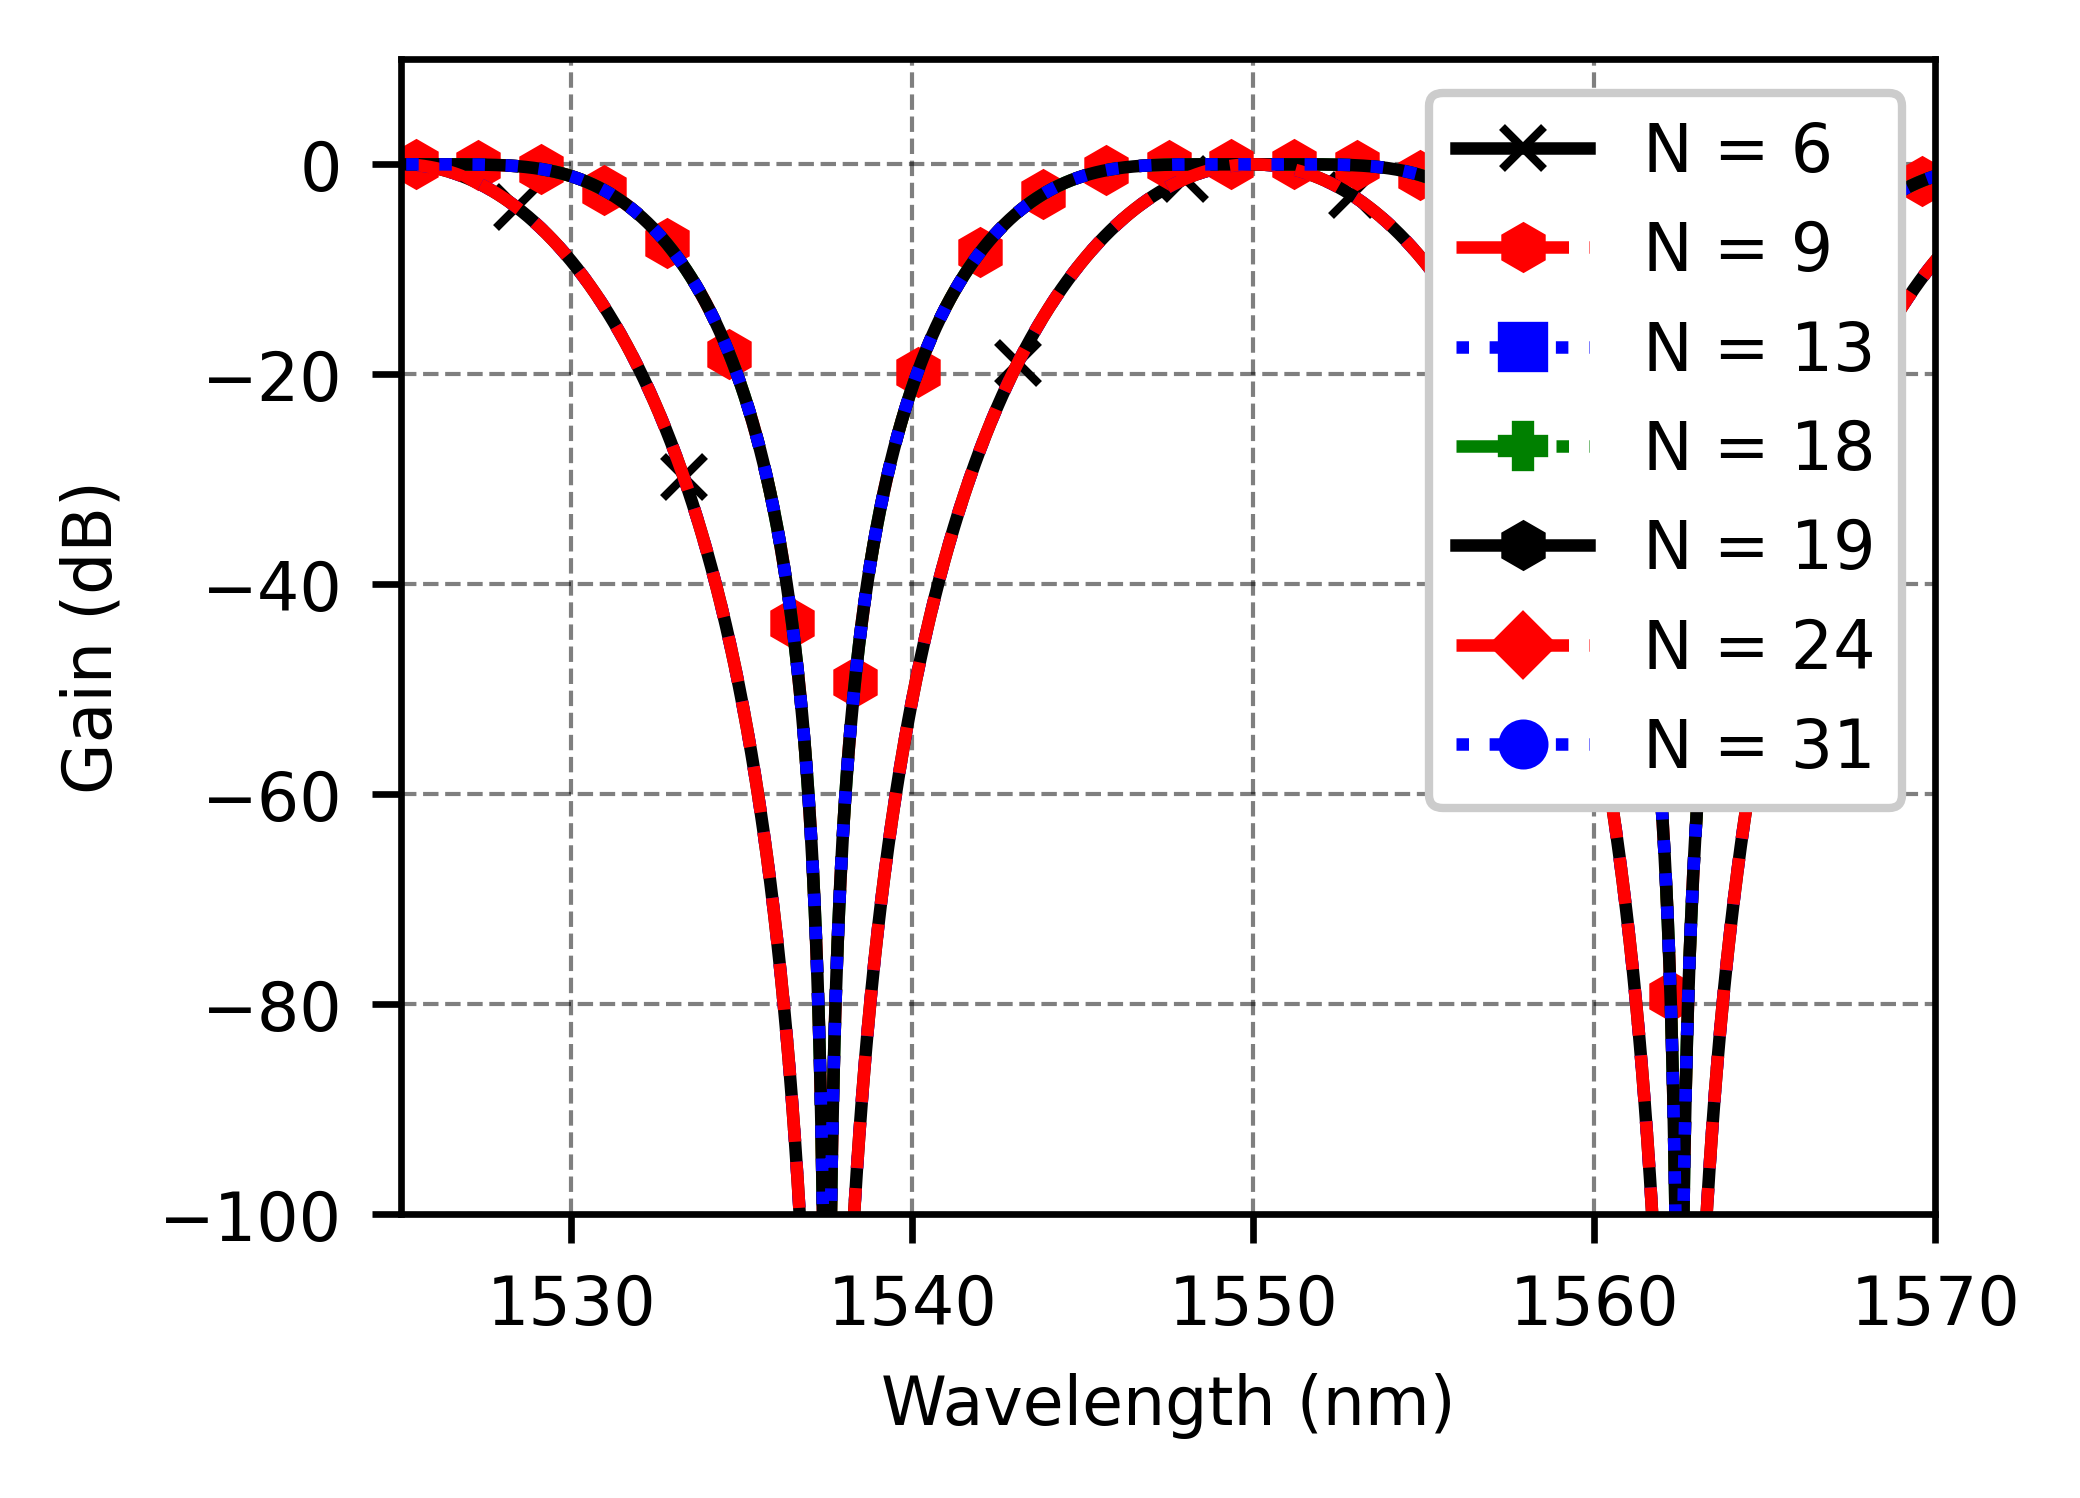

In [23]:
# Regression for G(z) and H(z)

# Can vary N from 0 to len(paired_filters) to change the pair
inapropriate_pairs = []
fig = plt.plot()
deltaL = calculate_delta_L(ng=ng, fsr=25e-9, lambda_0=lambda_0)
# Plotting the results
λ = np.linspace(simulationband[0]*1e9, simulationband[-1]*1e9, points)

A_base,B_base, = lambidify_filter(N=N, verbose=False, points=points)

for i in range(len(paired_filters)):

    pair = [paired_filters[i]]
    
    try:
        regression_results = regression_for_filter_pairs(3, pair)  # 3rd order, so N=3
    except:
        continue
    theta = regression_results[0][0]  # Get the first pair's theta
    phi = regression_results[0][1]  # Get the first pair's phi
    df_results = thetas_phis_df(theta, phi, False)


    Gz_coef = pair[0][0]
    A = sum(coeff * z**(-i) for i, coeff in enumerate(Gz_coef))
    # Transforming Z domain to frequency
    A_freq = A.subs(z, exp(I * ω))
    # Generating numerical function
    A_freq_func = sp.lambdify(ω, A_freq, 'numpy')
    # Obtaining the values for omega_vals
    desired_fsr = 25e-9
    pi_limits = (simulationband[0]-simulationband[-1])/desired_fsr*π # Calculate the omega span
    phase = 0 # allign the value with the desired phase
    omega_vals = np.linspace(-pi_limits+phase, pi_limits+phase, points) # Setting the omega values for the FSR calculation and optimization
    #print(-pi_limits)
    A_vals = np.abs(A_freq_func(omega_vals))
    # Use markers
    markers = ['o', '^', 's', 'D', 'v', 'x', '*', 'P', 'h', '+']
    marker = markers[i % len(markers)]
    threshold=0.2
    val, condition_up = curve_correlation(A_vals,A_base, threshold)

    markevery = max(1, len(λ)//20)-i
    if 20*np.log10(A_vals).max() > 0 or val<threshold:
        inapropriate_pairs.append(i)
        continue
    else:
        thetas_phis_df(theta, phi, True)
        plt.plot(λ, 20*np.log10(A_vals), label='N = '+str(i+1), marker=marker, markevery=markevery-i*50, ms=5)
    plt.legend(loc='upper right')
    plt.ylabel('Gain (dB)')
    plt.xlabel('Wavelength (nm)')
    plt.xlim(cband[0]*1e9, cband[-1]*1e9)
    plt.ylim(-100, 10)
    logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
plt.show()

Pair 6 low passed the correlation test with value: 0.3874
Pair 13 low passed the correlation test with value: 0.3874
Pair 24 low passed the correlation test with value: 0.3874


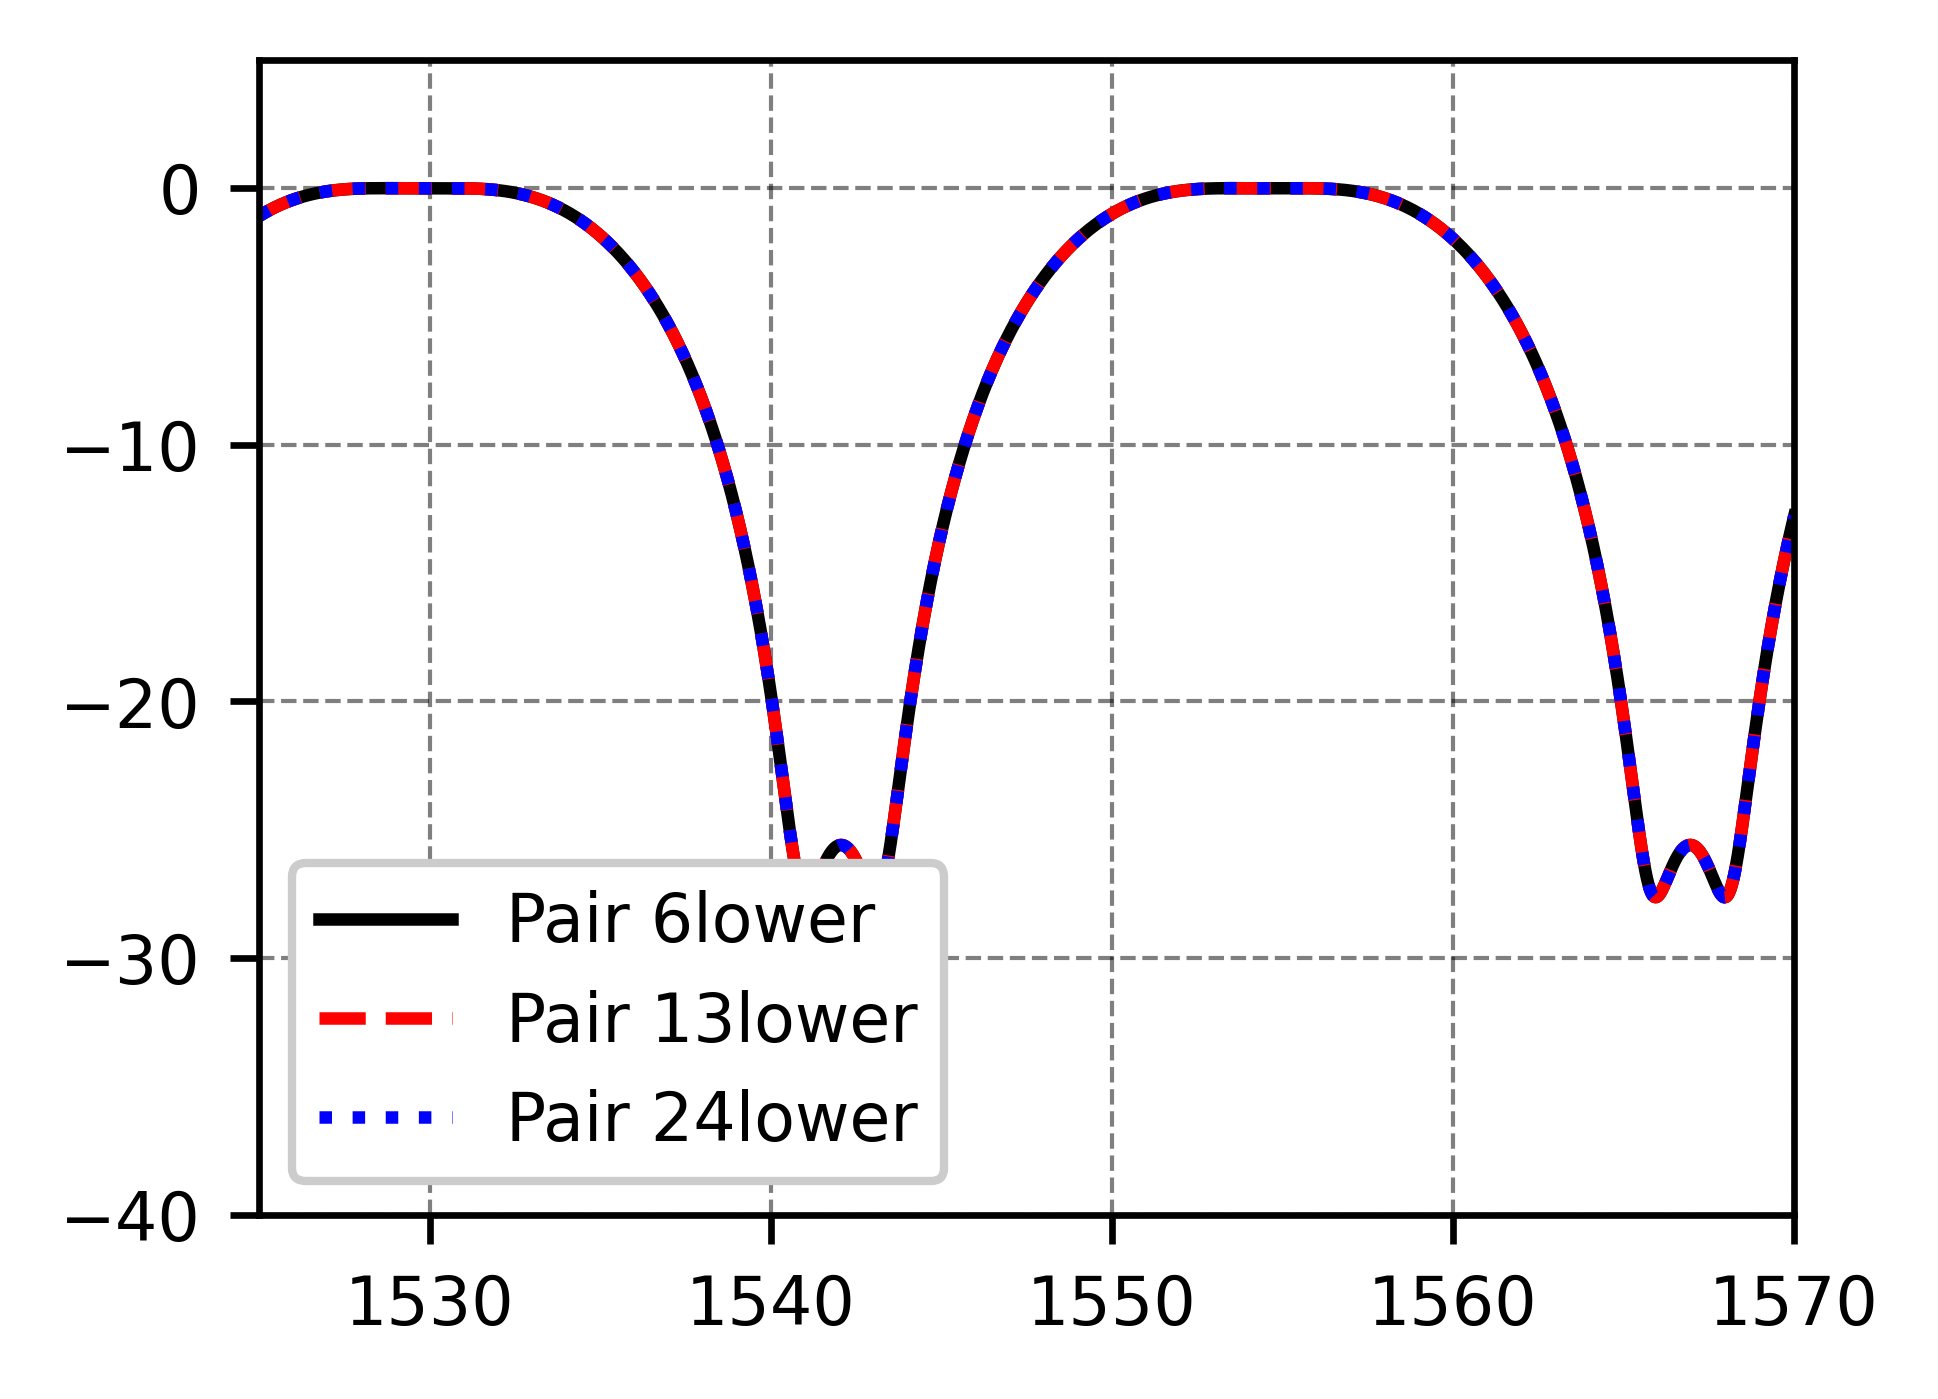

In [24]:
fig2 = plt.plot()

theta = [0]
phi = [0]

A_lamb,B_lamb, = lambidify_filter(N=N, verbose=False, points=points)

for i in range(len(paired_filters)):
    pair = [paired_filters[i]]
    if i in inapropriate_pairs:
        continue
    try:
        regression_results = regression_for_filter_pairs(N, pair)  # third order
    except:
        continue

    theta = regression_results[0][0]  # pair's theta
    phi   = regression_results[0][1]  # pair's phi

    df_results = thetas_phis_df(theta, phi, False)

    # skip configurations with any near-zero thetas
    if np.any(np.abs(theta) < 1e-3):
        continue
        
    
    theta_values_order = []
    phi_values_order = []
    for j in range(N+1):
        theta_values_order.append(theta[- 1 - j])
        if j > 0:
            phi_values_order.append(phi[ - 1 - j])


    create_mzi_of_order(
        inter=inter,
        order=N,
        thetas=theta_values_order,
        phis=phi_values_order,
        verbose=False
    )
    inter.switchtolayout()
    inter.run()

    upper_transmission = abs(inter.getresult('ONA_1', 'input 1/mode 1/transmission')['TE transmission'])**2
    lower_transmission = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2

    val, condition_up = curve_correlation(A_lamb,upper_transmission, threshold=0.25)
    val, condition_low = curve_correlation(B_lamb,lower_transmission, threshold=0.25)

    #if (condition_up and (-min(10*np.log10(upper_transmission))>20)):
    #    print(f"Pair {i+1} up passed the correlation test with value: {val:.4f}")
    #    plt.plot(λ, 10*np.log10(upper_transmission), label='Pair'+str(i+1)+' upper')
    if (condition_low and (-min(10*np.log10(lower_transmission))>15)):
        print(f"Pair {i+1} low passed the correlation test with value: {val:.4f}")
        plt.plot(λ, 10*np.log10(lower_transmission), label='Pair '+str(i+1)+ 'lower')
    plt.xlim([cband[0]*1e9, cband[-1]*1e9])
    plt.legend()
    plt.ylim([-40, 5])
        

In [25]:

pair = [paired_filters[0]]

regression_results = regression_for_filter_pairs(N, pair)  # third order

theta = regression_results[0][0]  # pair's theta
phi   = regression_results[0][1]  # pair's phi

df_results = thetas_phis_df(theta, phi, False)

theta_values_order = []
phi_values_order = []
for j in range(N+1):
    theta_values_order.append(theta[- 1 - j])
    if j > 0:
        phi_values_order.append(phi[ - 1 - j])


create_mzi_of_order(
    inter=inter,
    order=N,
    thetas=theta_values_order,
    phis=phi_values_order,
    verbose=False
)
inter.switchtolayout()
inter.run()
lower_transmission = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2
plt.figure();

pair = paired_filters[6]

delay, a1, a2_shifted = find_delay(lower_transmission, B)

plt.grid(True)
plt.plot(λ, 10*np.log10(np.roll(B,delay)), label='Theoretical H(z)');#, marker='^', markevery=3000, ms=4)
plt.plot(λ, 10*np.log10(lower_transmission), label='Simulated H(z)');#, marker='o', markevery=3000, ms=3)
plt.ylabel('Gain (dB)');
plt.legend(loc='upper right');
plt.xlabel('Wavelength (nm)');
plt.xlim(cband[0]*1e9,cband[-1]*1e9);
plt.ylim(-30, 10);
plt.xticks();
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

NameError: name 'B' is not defined

<Figure size 1980x1500 with 0 Axes>

Results for pair # 1


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.2499π,0.49969,-0.0000
Theta1,-0.4372π,0.96156,-0.0000
Theta0,-0.0461π,0.02087,--------


Pair 1 passed the correlation test with value: 0.3874
Results for pair # 2


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.2500π,0.49985,-0.0000
Theta1,-0.4372π,0.96155,-0.0000
Theta0,-0.0461π,0.02085,--------


Pair 2 passed the correlation test with value: 0.3874
Results for pair # 3


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.2500π,0.49985,-0.0000
Theta1,-0.4372π,0.96155,-0.0000
Theta0,-0.0461π,0.02085,--------


Pair 3 passed the correlation test with value: 0.3874
Results for pair # 4


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4096π,0.92148,-0.0000
Theta1,-0.1412π,0.18410,-0.0000
Theta0,-0.2451π,0.48445,--------


Results for pair # 6


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.2500π,0.50015,-0.0000
Theta1,-0.4372π,0.96153,-0.0000
Theta0,-0.0461π,0.02080,--------


Pair 6 passed the correlation test with value: 0.3874
Results for pair # 7


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4093π,0.92106,-0.0000
Theta1,-0.1410π,0.18381,-0.0000
Theta0,-0.2447π,0.48349,--------


Results for pair # 9


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4093π,0.92106,-0.0000
Theta1,-0.1410π,0.18381,-0.0000
Theta0,-0.2447π,0.48349,--------


Results for pair # 11


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4092π,0.92086,-0.0000
Theta1,-0.1410π,0.18366,-0.0000
Theta0,-0.2446π,0.48301,--------


Results for pair # 13


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.2500π,0.50015,-0.0000
Theta1,-0.4372π,0.96153,-0.0000
Theta0,-0.0461π,0.02080,--------


Pair 13 passed the correlation test with value: 0.3874
Results for pair # 14


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4093π,0.92106,-0.0000
Theta1,-0.1410π,0.18381,-0.0000
Theta0,-0.2447π,0.48349,--------


Results for pair # 16


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4092π,0.92086,-0.0000
Theta1,-0.1410π,0.18366,-0.0000
Theta0,-0.2446π,0.48301,--------


Results for pair # 18


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4091π,0.92065,-0.0000
Theta1,-0.1409π,0.18351,-0.0000
Theta0,-0.2444π,0.48254,--------


Results for pair # 19


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.0909π,0.07935,-0.0000
Theta1,-0.0000π,0.00000,-0.0000
Theta0,-0.0000π,0.00000,--------


Pair 19 passed the correlation test with value: 0.4097
Results for pair # 20


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4090π,0.92044,-0.0000
Theta1,-0.1409π,0.18337,-0.0000
Theta0,-0.2443π,0.48206,--------


Results for pair # 22


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4090π,0.92044,-0.0000
Theta1,-0.1409π,0.18337,-0.0000
Theta0,-0.2443π,0.48206,--------


Results for pair # 24


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-0.0000
Theta2,-0.2501π,0.50031,-0.0000
Theta1,-0.4371π,0.96152,-0.0000
Theta0,-0.0460π,0.02078,--------


Pair 24 passed the correlation test with value: 0.3874
Results for pair # 25


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4089π,0.92023,-0.0000
Theta1,-0.1408π,0.18322,-0.0000
Theta0,-0.2441π,0.48158,--------


Results for pair # 27


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4089π,0.92023,-0.0000
Theta1,-0.1408π,0.18322,-0.0000
Theta0,-0.2441π,0.48158,--------


Results for pair # 29


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4089π,0.92023,-0.0000
Theta1,-0.1408π,0.18322,-0.0000
Theta0,-0.2441π,0.48158,--------


Results for pair # 31


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.50000,-3.1416
Theta2,-0.4086π,0.91982,-0.0000
Theta1,-0.1407π,0.18292,-0.0000
Theta0,-0.2438π,0.48063,--------


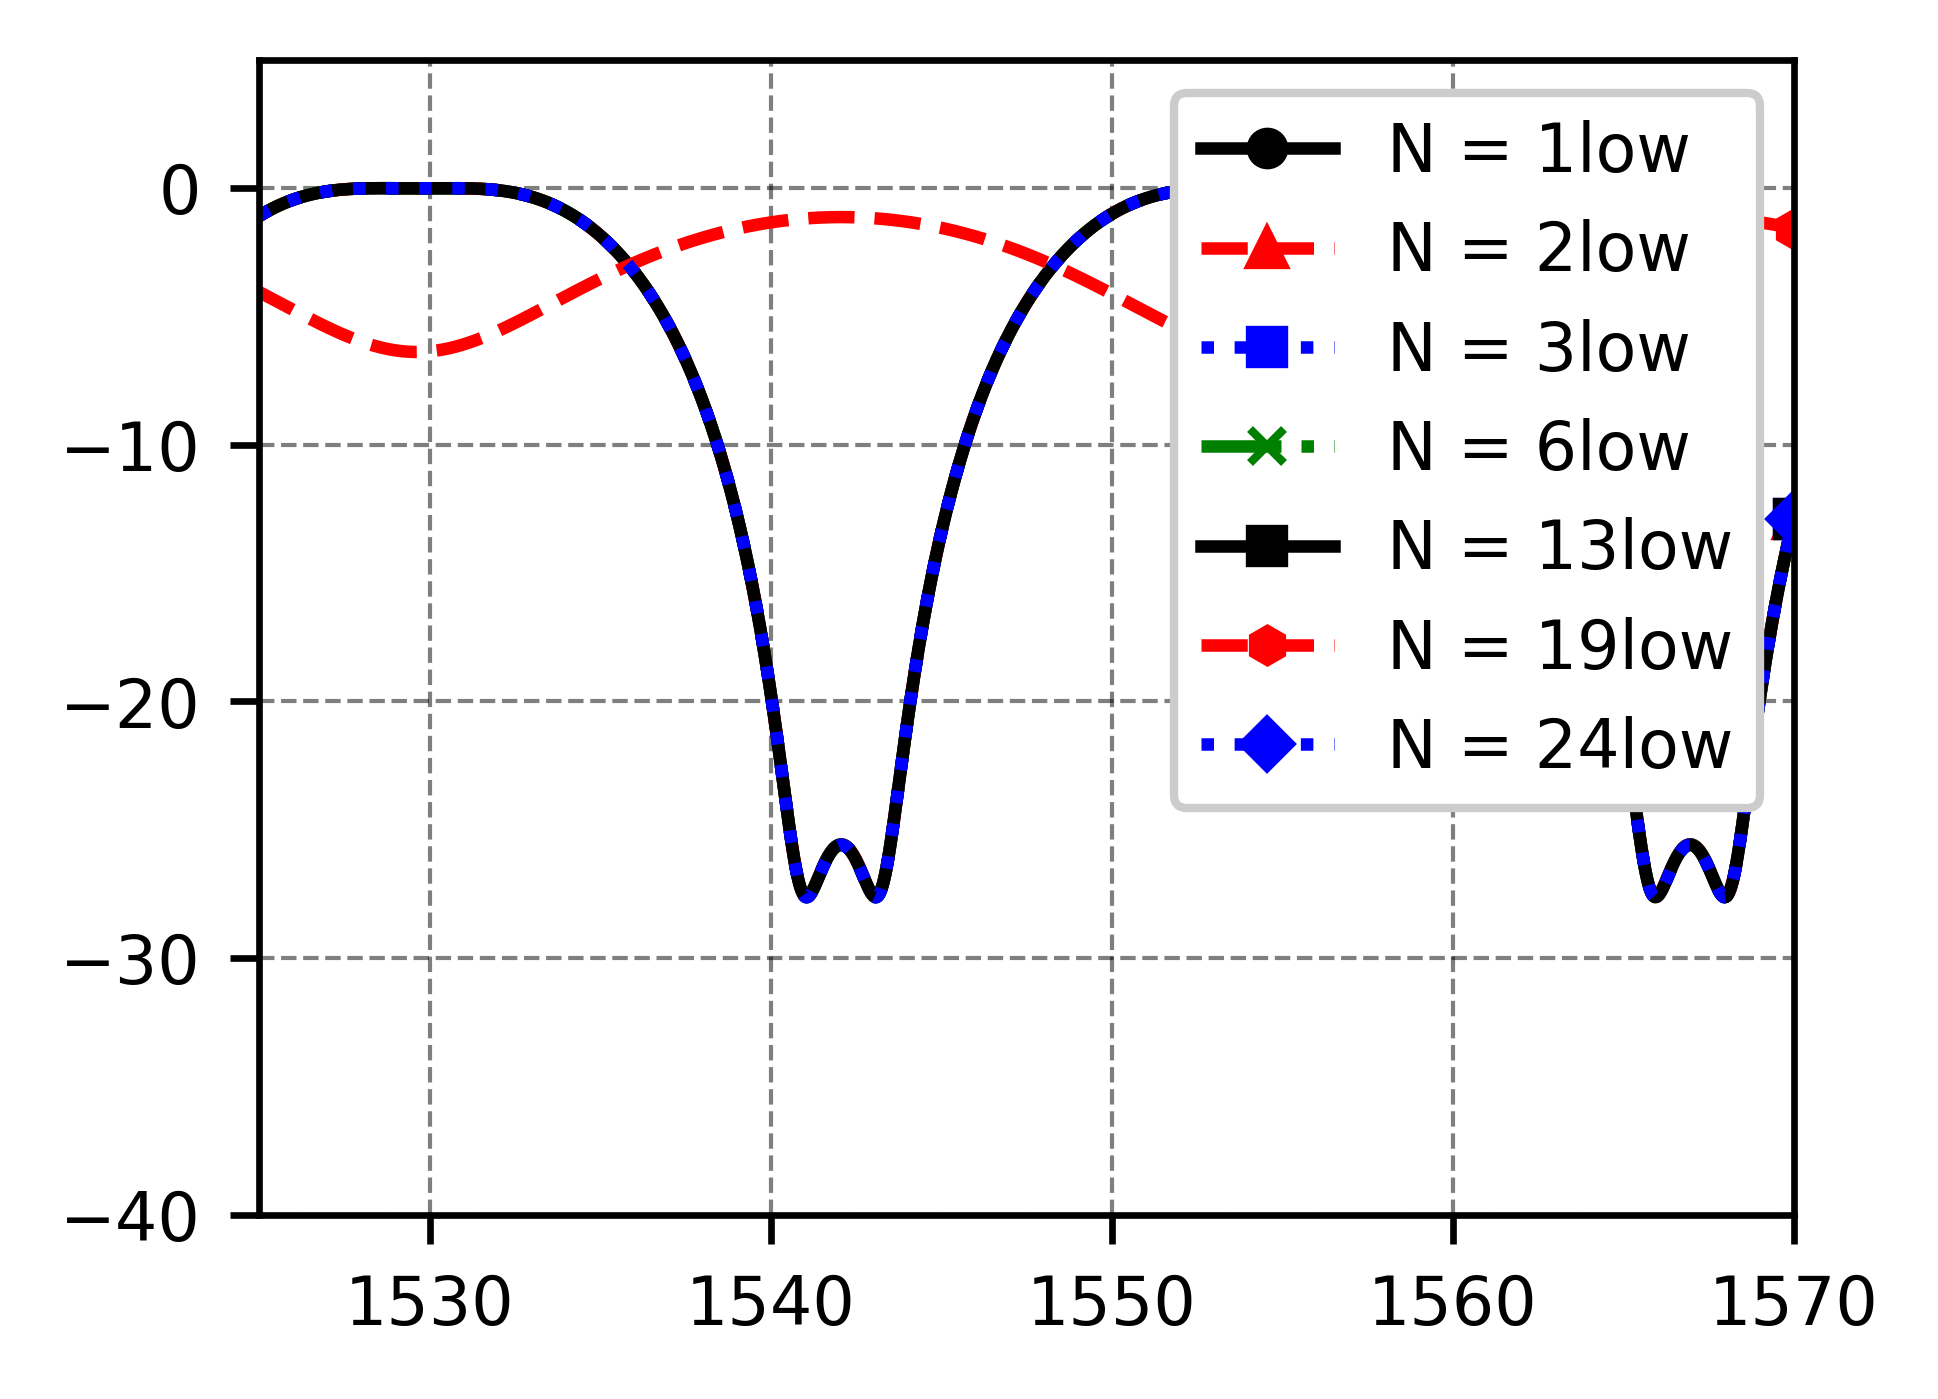

In [ ]:
fig3 = plt.plot()
for i in range(len(paired_filters)):
    
    pair = [paired_filters[i]]

    try:
        regression_results = regression_for_filter_pairs(N, pair)  # 3rd order, so N=3
    except:
        continue

    theta = regression_results[0][0]  # Get the first pair's theta
    phi = regression_results[0][1]  # Get the first pair's phi
    print('Results for pair #',i+1 )    
    df_results = thetas_phis_df(theta, phi, True)

    theta_values_order3 = [theta[3], theta[2], theta[1], theta[0]]
    #print('iteration',i,'Theta = ', theta_values_order3, ' Phi = ', phi)
    phi_values_order3 = [phi[2], phi[1], phi[0]]

    create_mzi_of_order(
        inter=inter, 
        order=N,
        thetas=theta_values_order3,
        phis=phi_values_order3,
        verbose=False
    )
    inter.switchtolayout()
    inter.run()

    upper_transmission3 = abs(inter.getresult('ONA_1', 'input 1/mode 1/transmission')['TE transmission'])**2
    lower_transmission3 = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2   

    marker = markers[i % len(markers)]

    val, condition_up = curve_correlation(A,upper_transmission3, threshold=0.25)
    val, condition_low = curve_correlation(B,lower_transmission3, threshold=0.25)

    #if (condition_up or np.min(10*np.log10(np.asarray(upper_transmission3, dtype=float))) < -20):
    #    print(f"Pair {i+1} passed the correlation test with value: {val:.4f}")
    #    plt.plot(λ, 10*np.log10(np.asarray(upper_transmission3, dtype=float)), label='N = '+str(i+1)+'up', marker=marker, markevery=3000, ms=4)
    if (condition_low or np.min(10*np.log10(np.asarray(upper_transmission3, dtype=float))) < -20):
        print(f"Pair {i+1} passed the correlation test with value: {val:.4f}")
        plt.plot(λ, 10*np.log10(np.asarray(lower_transmission3, dtype=float)), label='N = '+str(i+1)+'low', marker=marker, markevery=3000, ms=4)
    plt.legend(loc='upper right')
    plt.xlim([cband[0]*1e9, cband[-1]*1e9])
    plt.ylim([-40, 5])

# Fourth Order Test


In [ ]:
# Initial definitions 
l = 50e-6
simulationband = [1450e-9, 1650e-9]
lambda_0=1550e-9
cband = [1525e-9, 1570e-9]
ng = 4.2 # Silicon waveguide group index
neff = 2.44
dx = 125


In [ ]:
if 'inter' not in locals():
    lumapi = lumapi()
    inter = lumapi.INTERCONNECT()

In [ ]:
N = 4

#Call the main function to get the paired coefficients
paired_filters = find_filter_pairs(N=N, verbose=True, imag_threshold=1e-3, a0_precision=3)
print("\n--- Output Vector of Matched Coefficient Pairs ---")
if not paired_filters:
    print("No matched pairs were found.")
else:
    for i, pair in enumerate(paired_filters):
        print(f"\nPair #{i+1}")
        print(f"G(z) Coeffs (ak): {np.round(pair[0], 5)}")
        print(f"H(z) Coeffs (bk): {np.round(pair[1], 5)}")

--- Generating filters for N=4 and type='maximally_flat' ---

--- Processing A_k to find unique G(z) filters ---
Testing 3432 root combinations for A_k...
Found 21 unique G(z) candidates.

--- Processing B_k to find unique H(z) filters ---
Testing 3432 root combinations for B_k...
Found 20 unique H(z) candidates.

--- Pairing G(z) and H(z) filters based on closest a0 value ---
Found 20 matched pairs.

--- Output Vector of Matched Coefficient Pairs ---

Pair #1
G(z) Coeffs (ak): [-0.00777 -0.05447 -0.16367 -0.27322 -0.27366 -0.16446 -0.05491 -0.00786]
H(z) Coeffs (bk): [ 0.00757  0.02362 -0.02142 -0.13335  0.0176   0.44839 -0.50374  0.16134]

Pair #2
G(z) Coeffs (ak): [-0.02306 -0.13121 -0.30246 -0.35115 -0.19721 -0.02537  0.02273  0.00773]
H(z) Coeffs (bk): [ 0.02264  0.10094  0.06089 -0.3587  -0.44013  0.91526 -0.14339 -0.1575 ]

Pair #3
G(z) Coeffs (ak): [-0.05393 -0.24045 -0.39865 -0.27629 -0.04037  0.02449 -0.00706 -0.00775]
H(z) Coeffs (bk): [ 0.054   -0.02027 -0.35415  0.56777 -0

Order,Theta (π),k,Phi
Theta4,-0.4845π,0.99763,-3.1416
Theta3,-0.2664π,0.55148,3.1416
Theta2,-0.0907π,0.07903,3.1416
Theta1,-0.4417π,0.96682,-3.1416
Theta0,-0.2268π,0.42743,--------


Results for pair # 1


Order,Theta (π),k,Phi
Theta4,-0.4844π,0.99760,-3.1416
Theta3,-0.2172π,0.39765,0.0000
Theta2,-0.2127π,0.38399,-0.0000
Theta1,-0.1108π,0.11637,-3.1416
Theta0,-0.2125π,0.38332,--------


Results for pair # 2


Order,Theta (π),k,Phi
Theta4,-0.2478π,0.49321,-0.0000
Theta3,-0.3089π,0.68087,-3.1416
Theta2,-0.4998π,1.00000,3.1416
Theta1,-0.4964π,0.99987,0.0000
Theta0,-0.4659π,0.98855,--------


Results for pair # 10


Order,Theta (π),k,Phi
Theta4,-0.2500π,0.50000,-0.0000
Theta3,-0.2275π,0.42961,-0.0000
Theta2,-0.3788π,0.86192,-0.0000
Theta1,-0.2902π,0.62492,-0.0000
Theta0,-0.3420π,0.77307,--------


Results for pair # 17


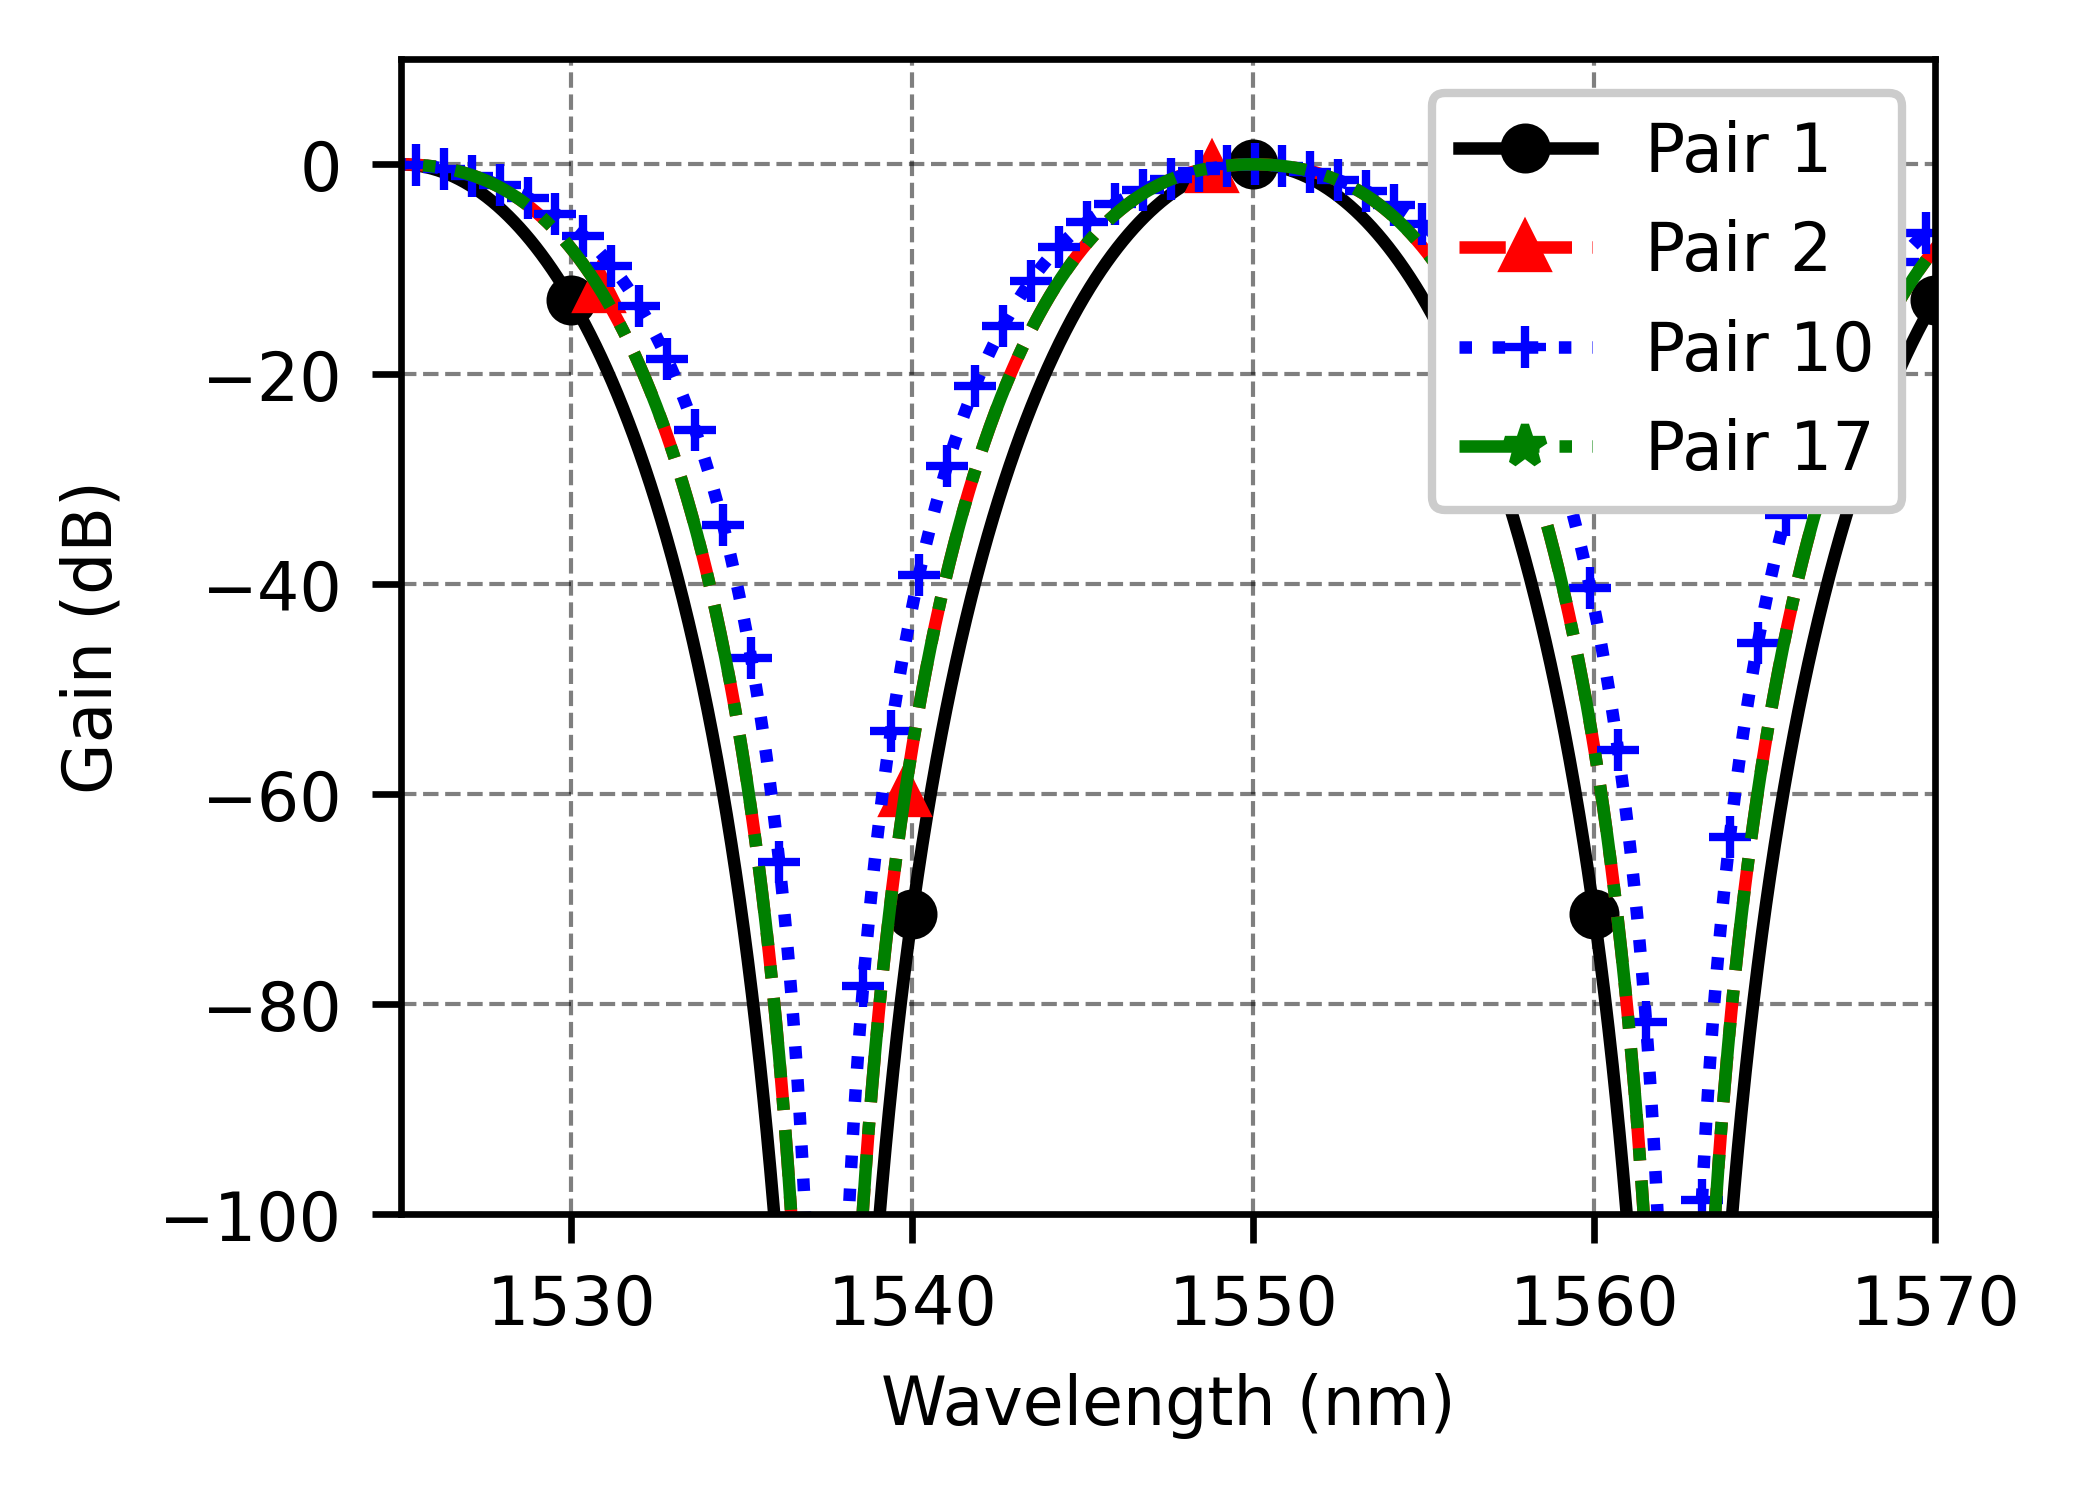

In [ ]:
# Regression for G(z) and H(z)

# Can vary N from 0 to len(paired_filters) to change the pair
inapropriate_pairs = []
fig = plt.plot()
deltaL = calculate_delta_L(ng=ng, fsr=25e-9, lambda_0=lambda_0)
# Plotting the results
λ = np.linspace(simulationband[0]*1e9, simulationband[-1]*1e9, points)

A_base,B_base, = lambidify_filter(N=N, verbose=False, points=points)

for i in range(len(paired_filters)):

    pair = [paired_filters[i]]
    
    try:
        regression_results = regression_for_filter_pairs(N, pair)  # 4rd order
    except:
        continue
    theta = regression_results[0][0]  # Get the first pair's theta
    phi = regression_results[0][1]  # Get the first pair's phi
    df_results = thetas_phis_df(theta, phi, False)


    Gz_coef = pair[0][0]
    A = sum(coeff * z**(-i) for i, coeff in enumerate(Gz_coef))
    # Transforming Z domain to frequency
    A_freq = A.subs(z, exp(I * ω))
    # Generating numerical function
    A_freq_func = sp.lambdify(ω, A_freq, 'numpy')
    # Obtaining the values for omega_vals
    desired_fsr = 25e-9
    pi_limits = (simulationband[0]-simulationband[-1])/desired_fsr*π # Calculate the omega span
    phase = 0 # allign the value with the desired phase
    omega_vals = np.linspace(-pi_limits+phase, pi_limits+phase, points) # Setting the omega values for the FSR calculation and optimization
    #print(-pi_limits)
    A_vals = np.abs(A_freq_func(omega_vals))
    # Use markers
    markers = ['o', '^', 's', 'D', 'v', 'x', '*', 'P', 'h', '+']
    marker = markers[i % len(markers)]
    threshold=0.5
    val, condition_up = curve_correlation(A_vals,A_base, threshold)

    markevery = max(1, len(λ)//20)-i
    if 20*np.log10(A_vals).max() > 0 or val<threshold:
        inapropriate_pairs.append(i)
        continue
    else:
        thetas_phis_df(theta, phi, True)
        print('Results for pair #',i+1 )
        plt.plot(λ, 20*np.log10(A_vals), label='Pair '+str(i+1), marker=marker, markevery=markevery-i*50, ms=5)
    plt.legend(loc='upper right')
    plt.ylabel('Gain (dB)')
    plt.xlabel('Wavelength (nm)')
    plt.xlim(cband[0]*1e9, cband[-1]*1e9)
    plt.ylim(-100, 10)
    logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
plt.show()

In [ ]:
print("Inapropriate pairs (G(z) with gain > 0 dB):", len(inapropriate_pairs), "->", inapropriate_pairs)

Inapropriate pairs (G(z) with gain > 0 dB): 16 -> [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19]


C:\Users\Leo\AppData\Local\Temp\ipykernel_24120\2793735980.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Pair 10 up passed the correlation test with value: 0.3936


Order,Theta (π),k,Phi
Theta4,-0.2478π,0.49321,-0.0000
Theta3,-0.3089π,0.68087,-3.1416
Theta2,-0.4998π,1.00000,3.1416
Theta1,-0.4964π,0.99987,0.0000
Theta0,-0.4659π,0.98855,--------


Pair 10 low passed the correlation test with value: 0.3936


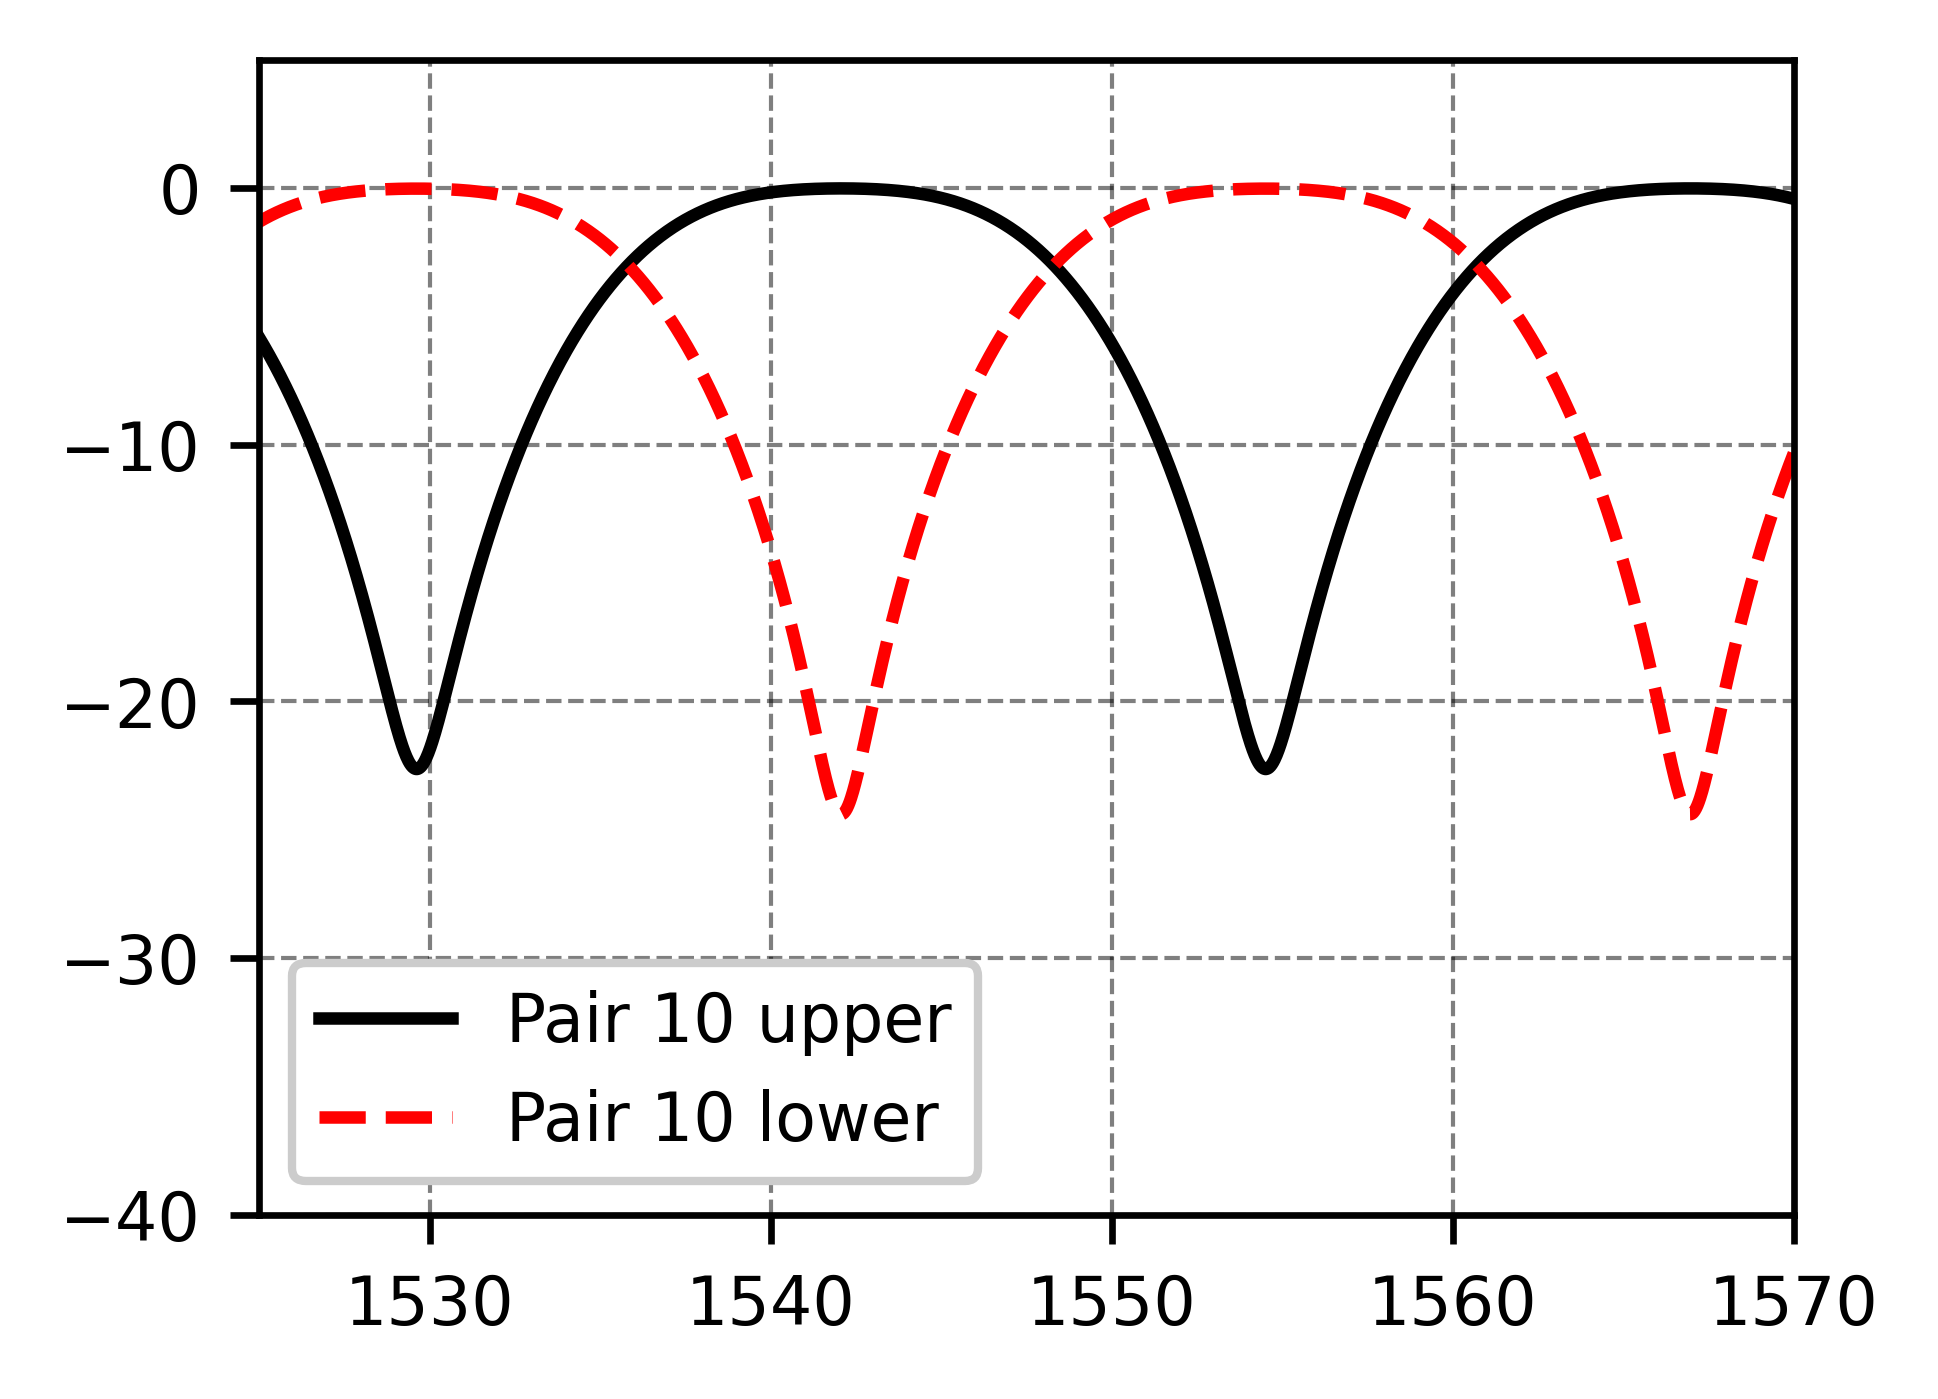

In [ ]:
fig2 = plt.plot()

theta = [0]
phi = [0]

A_lamb,B_lamb, = lambidify_filter(N=N, verbose=False, points=points)
seen_autocorrelationup = []
seen_autocorrelationdown = []

for i in range(len(paired_filters)):
    pair = [paired_filters[i]]
    if i in inapropriate_pairs:
        continue
    try:
        regression_results = regression_for_filter_pairs(N, pair)  # fourth order
    except:
        continue

    theta = regression_results[0][0]  # pair's theta
    phi   = regression_results[0][1]  # pair's phi

    df_results = thetas_phis_df(theta, phi, False)

    # skip configurations with any near-zero thetas
    if np.any(np.abs(theta) < 1e-3):
        continue
        
    
    theta_values_order = []
    phi_values_order = []
    for j in range(N+1):
        theta_values_order.append(theta[- 1 - j])
        if j > 0:
            phi_values_order.append(phi[ - 1 - j])


    create_mzi_of_order(
        inter=inter,
        order=N,
        thetas=theta_values_order,
        phis=phi_values_order,
        verbose=False
    )
    inter.switchtolayout()
    inter.run()

    upper_transmission = abs(inter.getresult('ONA_1', 'input 1/mode 1/transmission')['TE transmission'])**2
    lower_transmission = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2

    val, condition_up = curve_correlation(A_lamb,upper_transmission, threshold=0.1)
    val, condition_low = curve_correlation(B_lamb,lower_transmission, threshold=0.1)

    if (condition_up and (-min(10*np.log10(upper_transmission))>15) and condition_up not in seen_autocorrelationup):
        print(f"Pair {i+1} up passed the correlation test with value: {val:.4f}")
        seen_autocorrelationup.append(condition_up)
        thetas_phis_df(theta, phi, True)
        plt.plot(λ, 10*np.log10(upper_transmission), label='Pair '+str(i+1)+' upper')
    if (condition_low and (-min(10*np.log10(lower_transmission))>15) and condition_low not in seen_autocorrelationdown):
        print(f"Pair {i+1} low passed the correlation test with value: {val:.4f}")
        seen_autocorrelationdown.append(condition_low)
        plt.plot(λ, 10*np.log10(lower_transmission), label='Pair '+str(i+1)+ ' lower')
    plt.xlim([cband[0]*1e9, cband[-1]*1e9])
    plt.legend()
    plt.ylim([-40, 5])
        

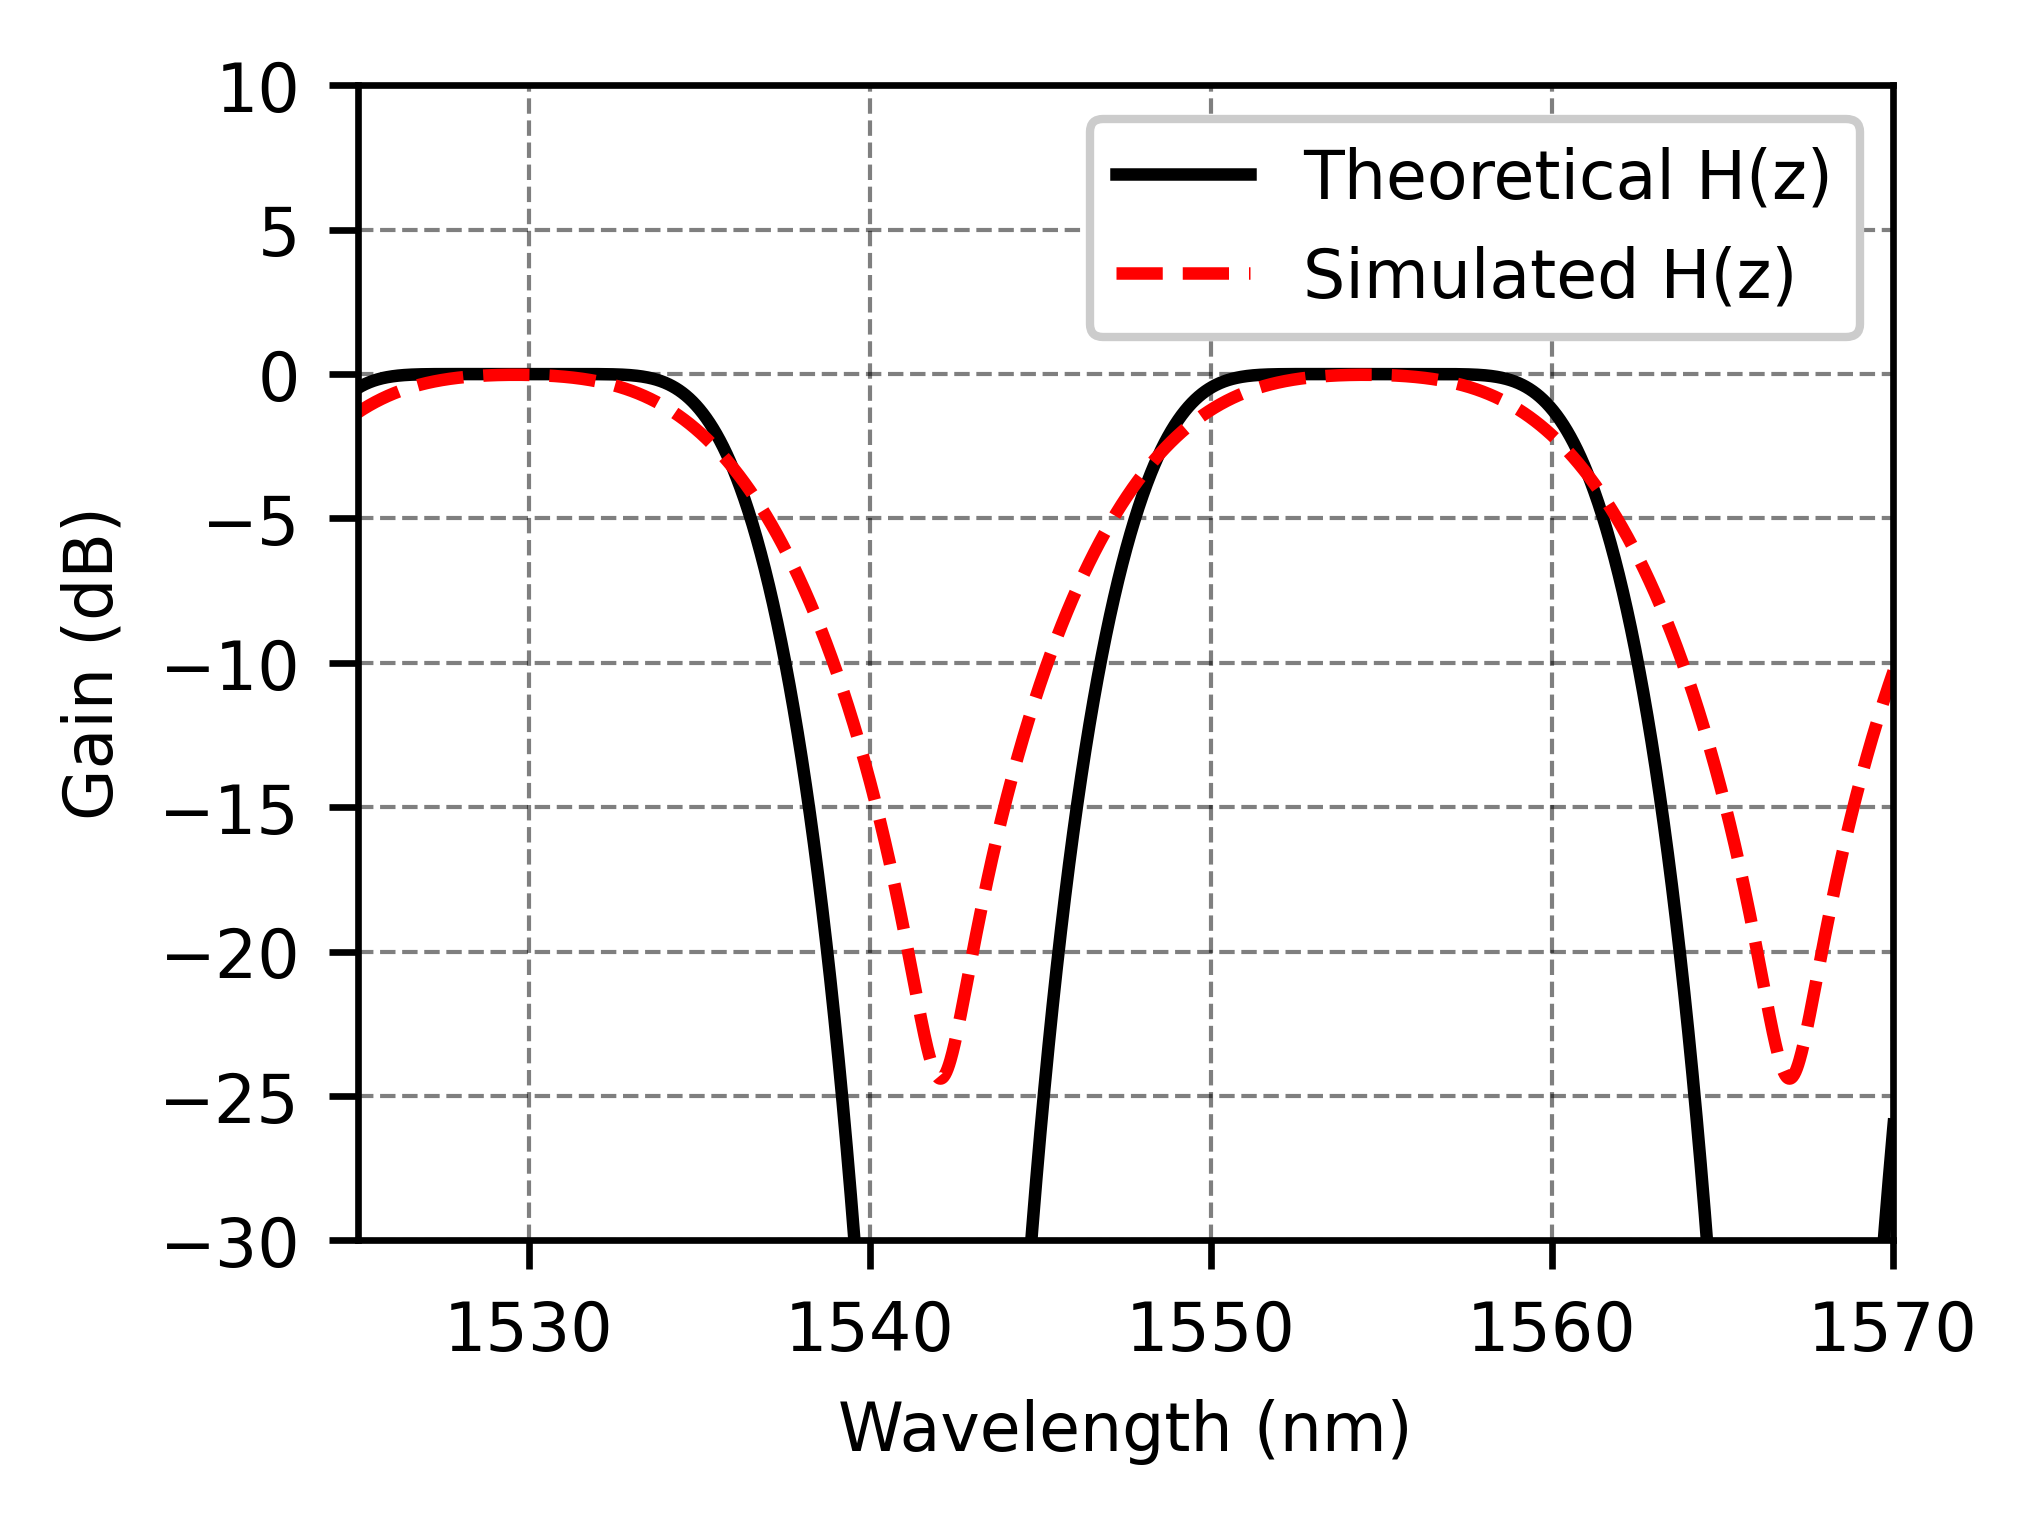

In [ ]:

pair = [paired_filters[9]]

regression_results = regression_for_filter_pairs(N, pair)  # third order

theta = regression_results[0][0]  # pair's theta
phi   = regression_results[0][1]  # pair's phi

df_results = thetas_phis_df(theta, phi, False)

theta_values_order = []
phi_values_order = []
for j in range(N+1):
    theta_values_order.append(theta[- 1 - j])
    if j > 0:
        phi_values_order.append(phi[ - 1 - j])


create_mzi_of_order(
    inter=inter,
    order=N,
    thetas=theta_values_order,
    phis=phi_values_order,
    verbose=False
)
inter.switchtolayout()
inter.run()
lower_transmission = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2
plt.figure();

pair = paired_filters[6]

delay, a1, a2_shifted = find_delay(lower_transmission, B)

plt.grid(True)
plt.plot(λ, 10*np.log10(np.roll(B,delay)), label='Theoretical H(z)');#, marker='^', markevery=3000, ms=4)
plt.plot(λ, 10*np.log10(lower_transmission), label='Simulated H(z)');#, marker='o', markevery=3000, ms=3)
plt.ylabel('Gain (dB)');
plt.legend(loc='upper right');
plt.xlabel('Wavelength (nm)');
plt.xlim(cband[0]*1e9,cband[-1]*1e9);
plt.ylim(-30, 10);
plt.xticks();
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

## Work in Progress
This cells have unfinished functions and tests, currently this notebook is aiming to achieve simulations directly in python without Lumerical licenses.

In [ ]:


def S_k(theta_k, phi_k, z):
    """
    Computes the composite scattering matrix S_k for one lattice stage:
    includes delay line (Sd), phase shifter (Sp), and directional coupler (Sc).
    """
    j = 1j

    # Delay line matrix
    Sd = np.array([
        [z**(-0.5), 0],
        [0, z**(0.5)]
    ], dtype=complex)

    # Phase shifter matrix
    Sp = np.array([
        [np.exp(-j * phi_k / 2), 0],
        [0, np.exp(j * phi_k / 2)]
    ], dtype=complex)

    # Directional coupler matrix
    Sc = np.array([
        [np.cos(theta_k), -j * np.sin(theta_k)],
        [-j * np.sin(theta_k), np.cos(theta_k)]
    ], dtype=complex)

    # Full section matrix
    Sk = Sd @ Sp @ Sc
    return Sk


def Lattice_Transfer_Matrix(theta, phi, z):

    N = len(theta)
    if len(phi) < N:
        phi = list(phi) + [0] * (N - len(phi))  

    
    T = np.eye(2, dtype=complex)

    
    for i in range(N - 1, -1, -1):
        z_eff = z**1 if i == N - 1 else z**(2)
        T = S_k(theta[i], phi[i], z_eff) @ T

    return T


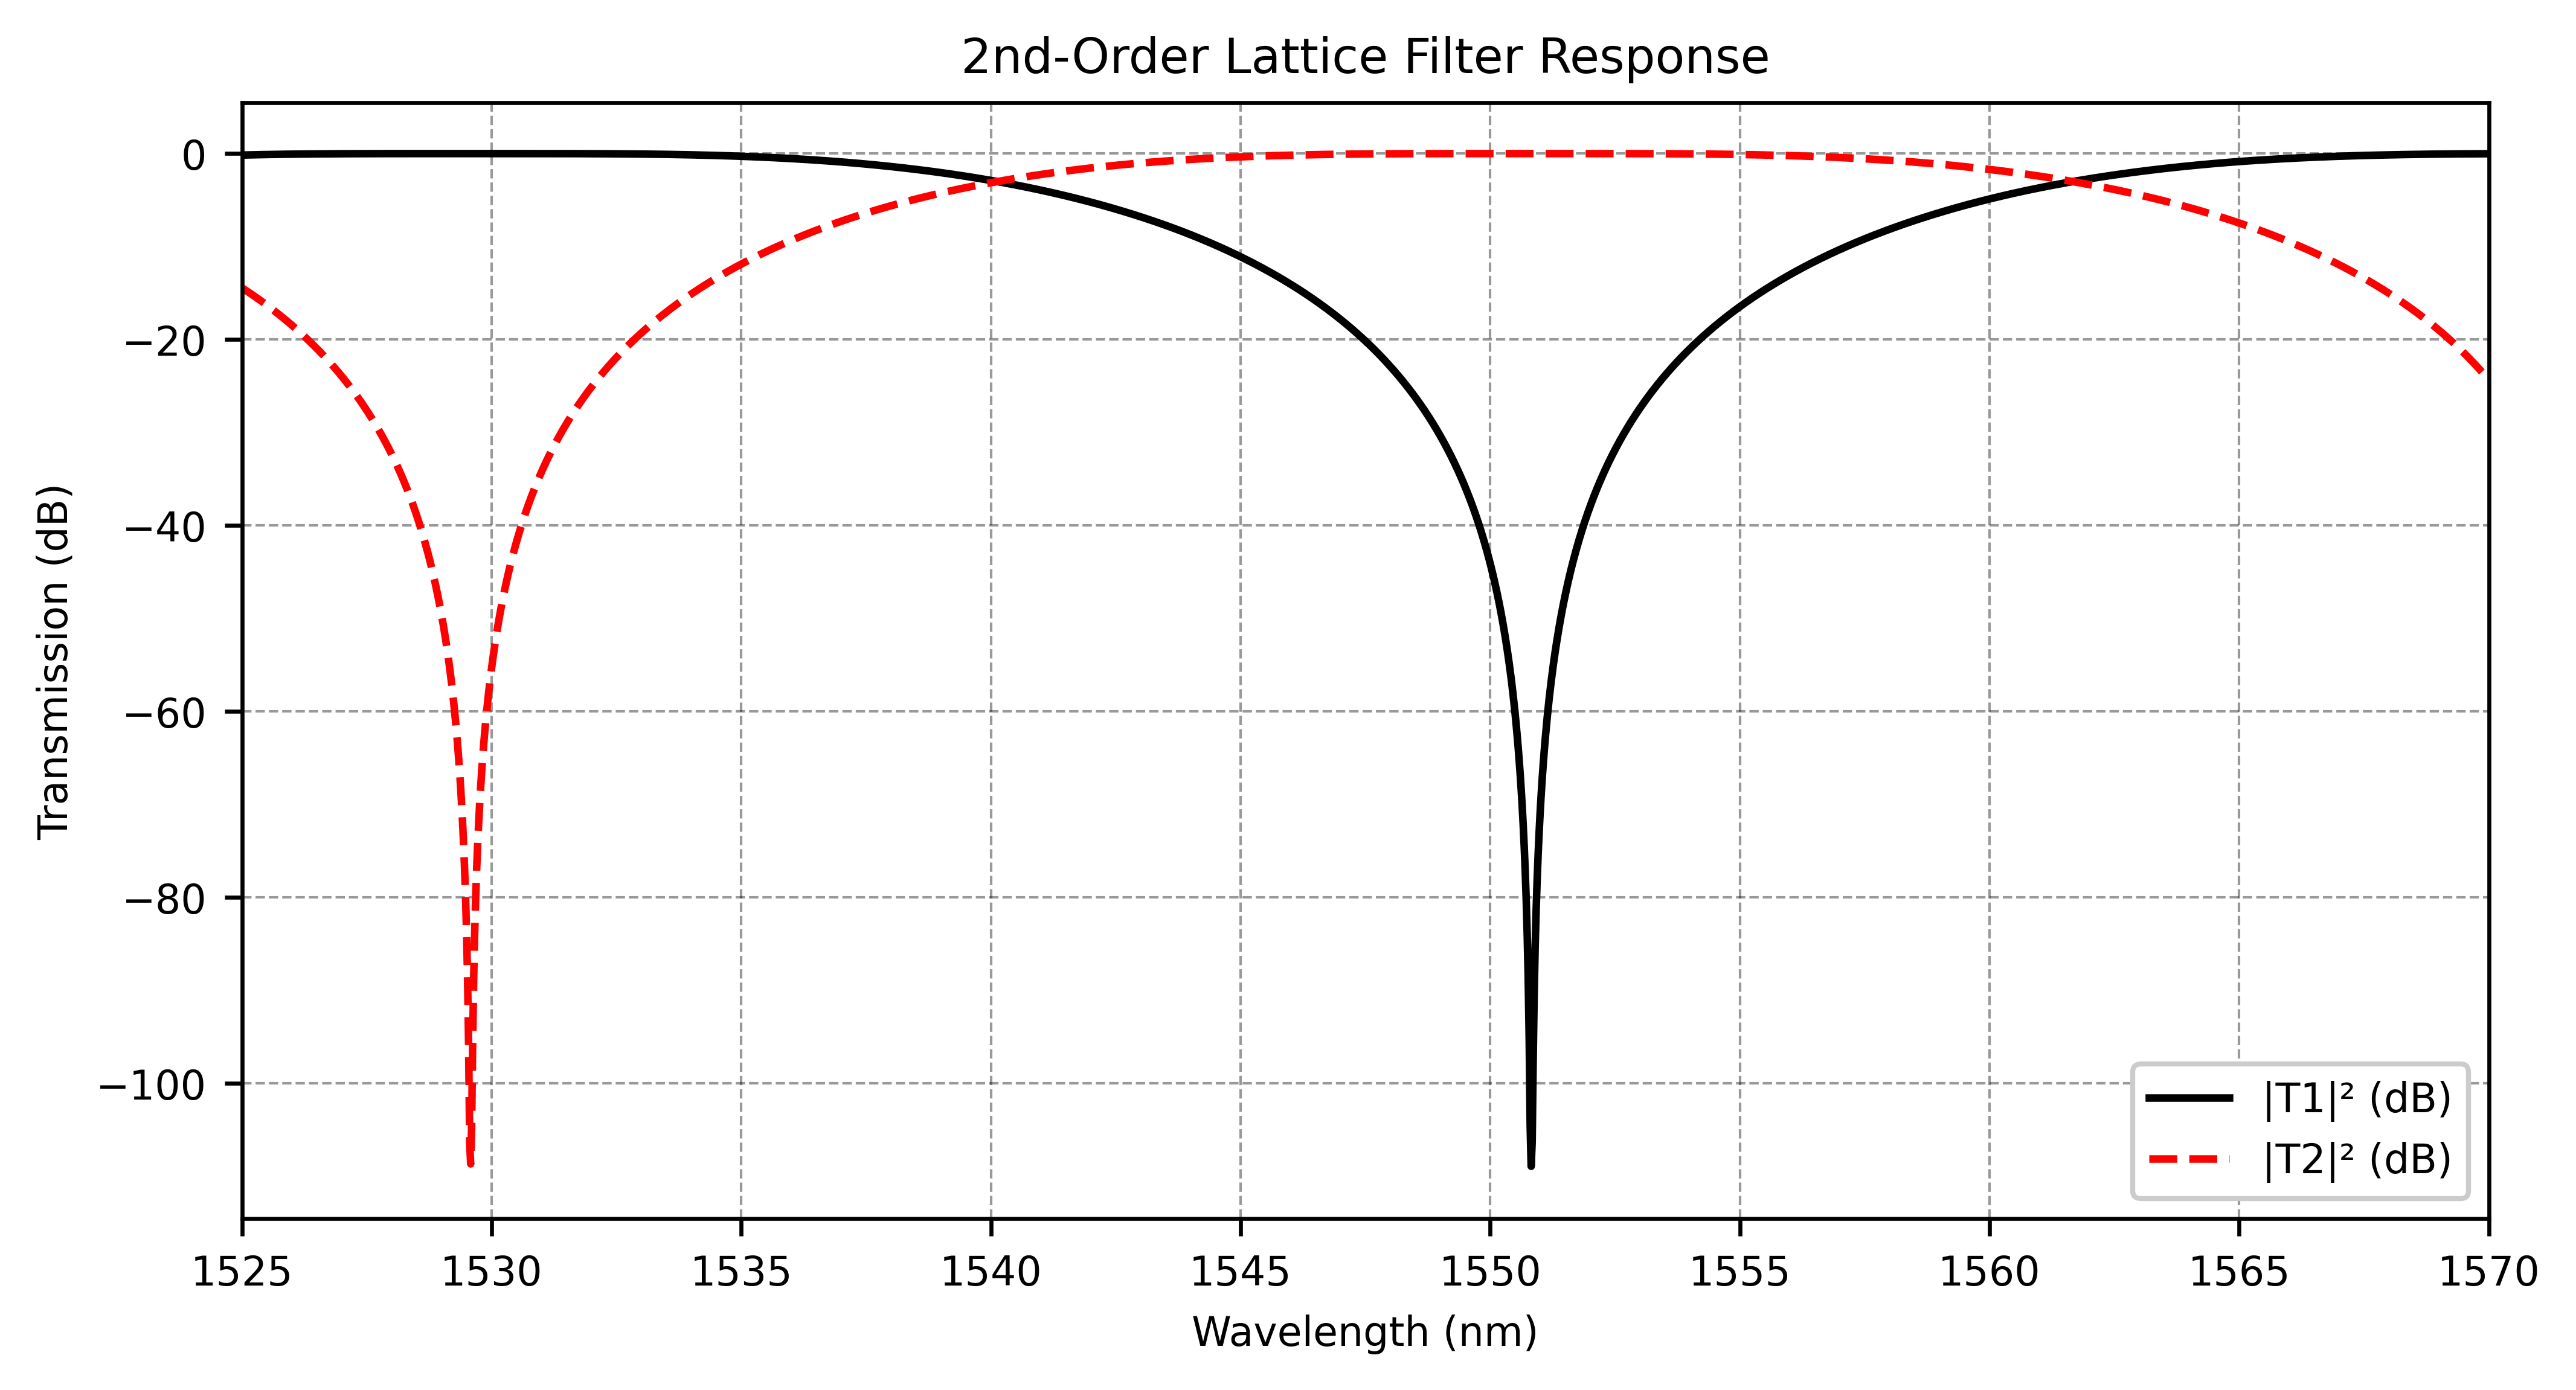

In [ ]:
theta = np.array([-0.4167*np.pi, -0.3333*np.pi, -0.25*np.pi])  
phi = np.array([0, -0.0000, -3.1416])                          
ΔL = 22.8810e-6  
neff = 2.44
lmbd0 = 1550e-9


lmbd = np.linspace(1450e-9, 1650e-9, points)
β = 2 * np.pi*neff/ lmbd
z = np.exp(1j * β*ΔL)

# Compute transfer spectra
T1 = np.zeros_like(lmbd, dtype=float)
T2 = np.zeros_like(lmbd, dtype=float)

for i in range(len(lmbd)):
    T = Lattice_Transfer_Matrix(theta, phi, z[i])
    T1[i] = np.abs(T[0, 0])**2
    T2[i] = np.abs(T[1, 0])**2  

# ---------- Plot results ----------
plt.figure(figsize=(8,4))
plt.plot(lmbd*1e9, 10*np.log10(T1), label='|T1|² (dB)')
plt.plot(lmbd*1e9, 10*np.log10(T2), label='|T2|² (dB)')
plt.title('2nd-Order Lattice Filter Response')
plt.xlabel('Wavelength (nm)')
plt.xlim(cband[0]*1e9, cband[-1]*1e9)
plt.ylabel('Transmission (dB)')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()